In [1]:
import pickle 

import numpy as np 

from utils import METRICS, MODEL_SIZES, sort_and_filter_metrics, CHECKPOINT_STEPS

from transformers import AutoConfig

from matplotlib import pyplot as plt 


/home/rd654/.cache/pypoetry/virtualenvs/pretraining-playground-YJRPv6z4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Correlation between SVD and CKA Scores 

Note that the hypothesis is that the weights that converge faster in a larger matrix are those that are more
full rank.

First analysis we want to run if how the singular values correlate with the CKA scores. 

Note:
1. we can then conduct the same analysis with the grad svd weights;
2. we can also do this analysis on a per-head layer basis

In [74]:
def compute_explained_variance(S):
    """ For a matrix of singular values, compute the explained variance."""
    variances = S**2 / S.numel()
    explained_variances = variances / np.sum(variances)
    return explained_variances

def compute_condition_number(S, matrix_rank=None):
    """ For a matrix of singular values, compute the condition number."""
    if matrix_rank is None:
        matrix_rank = len(S)
    return S[0] / S[matrix_rank - 1]

def compute_effective_rank(S, matrix_rank):
    """ Compute the effective rank of a matrix as defined by the entropy of the standardized eigenvalues"""

    limited_S = S[:matrix_rank]
    # stand_S = limited_S / limited_S[0]
    stand_S = limited_S / np.linalg.norm(limited_S, ord=1) # Standardize the singular values
    # stand_S = limited_S / np.sum(limited_S) # Standardize the singular values
    return np.exp(-np.sum(stand_S * np.log(stand_S)))/len(stand_S)


### Plotting Averaged Singular Values

Computing **averaged effective** rank over all layers of a given model size

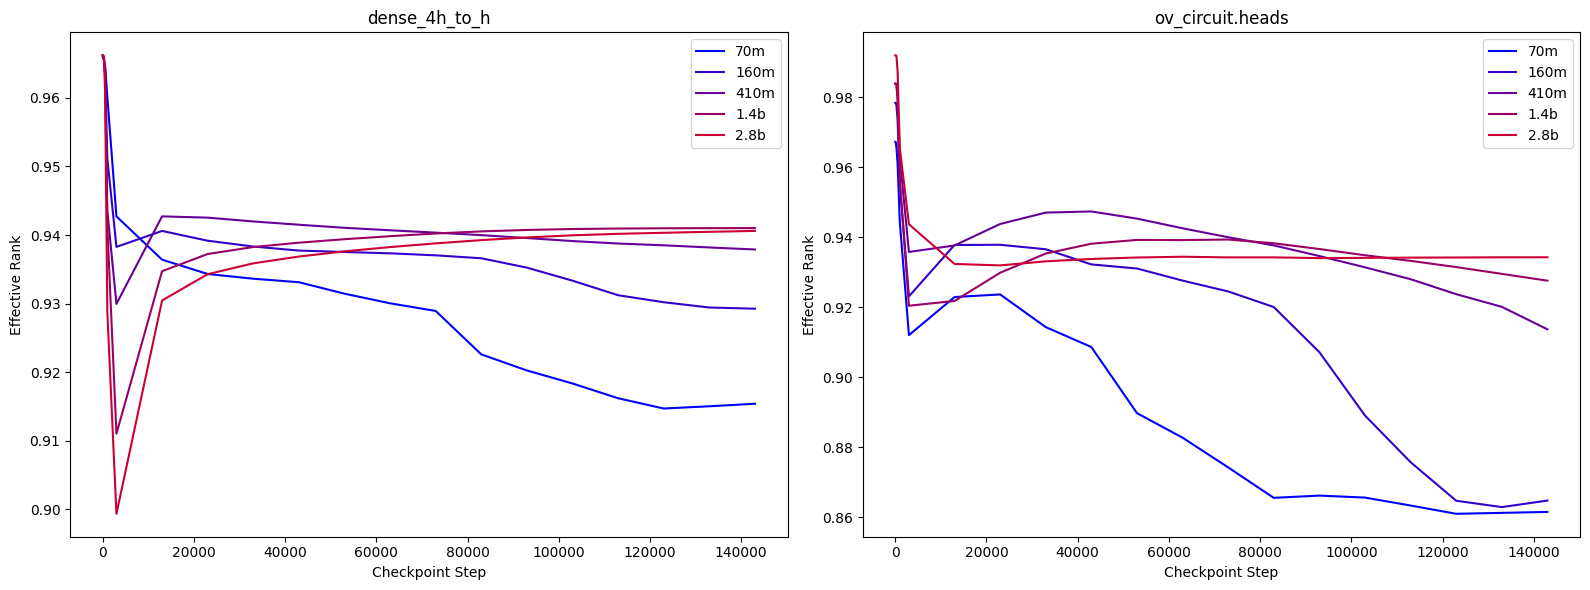

In [75]:
CIRCUIT_NAMES = ["dense_4h_to_h", "ov_circuit.heads"]

fix, axs = plt.subplots(1, 2, figsize=(16,6))

for circuit_idx, circuit_name in enumerate(CIRCUIT_NAMES): 
    for model_size_idx, model_size in enumerate(MODEL_SIZES):
        model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

        axs[circuit_idx].set_title(f"{circuit_name}")

        with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
            _svd_weights = pickle.load(f)
            model_singular_values = sort_and_filter_metrics(_svd_weights, circuit_name,)
    
        # Stores for each checkpoint the effective rank of the model across all layers
        averaged_effective_ranks = np.zeros(len(CHECKPOINT_STEPS))

        for layer_idx, (layer_name, layer_singular_values) in enumerate(model_singular_values.items()):

            # Iterating over all of the layers 

            matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

            # Effective ranks for a given layer over the course of all checkpoints
            effective_ranks = [compute_effective_rank(checkpoint_layer_singular_values, matrix_rank=matrix_rank) for checkpoint_layer_singular_values in layer_singular_values]

            averaged_effective_ranks += np.array(effective_ranks)
  
        # dividing by the number of layers
        averaged_effective_ranks /= len(model_singular_values)

        color = (model_size_idx / len(MODEL_SIZES), 0, 1 - model_size_idx / len(MODEL_SIZES))

        axs[circuit_idx].plot(CHECKPOINT_STEPS, averaged_effective_ranks, label=model_size, color=color)
        
    axs[circuit_idx].legend()
    axs[circuit_idx].set_xlabel("Checkpoint Step")
    axs[circuit_idx].set_ylabel("Effective Rank")

plt.tight_layout()
plt.show()


Computing **condition number** rank over all layers of a given model size

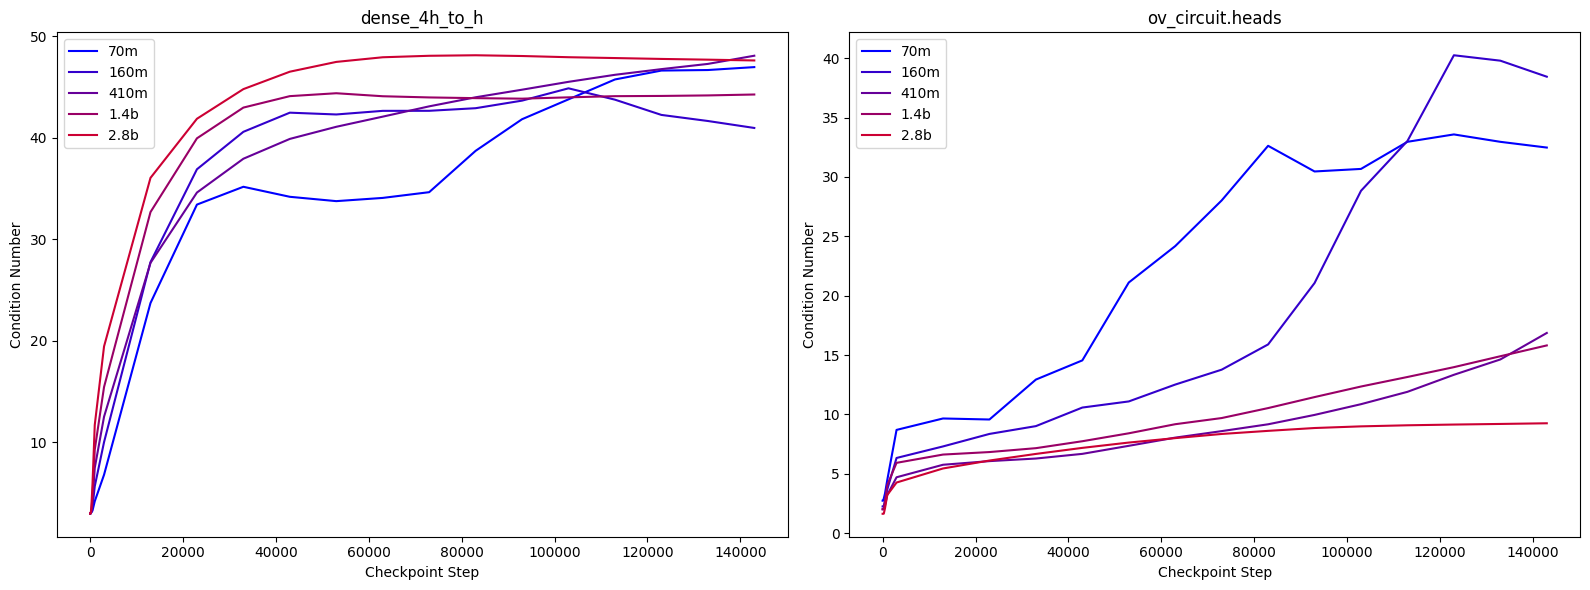

In [71]:
CIRCUIT_NAMES = ["dense_4h_to_h", "ov_circuit.heads"]

fix, axs = plt.subplots(1, 2, figsize=(16,6))

for circuit_idx, circuit_name in enumerate(CIRCUIT_NAMES): 
    for model_size_idx, model_size in enumerate(MODEL_SIZES):
        model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

        axs[circuit_idx].set_title(f"{circuit_name}")

        with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
            _svd_weights = pickle.load(f)
            model_singular_values = sort_and_filter_metrics(_svd_weights, circuit_name,)
    
        averaged_condition_numbers = np.zeros(len(CHECKPOINT_STEPS))

        for layer_idx, (layer_name, layer_singular_values) in enumerate(model_singular_values.items()):

            matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

            condition_numbers = [compute_condition_number(checkpoint_layer_singular_values, matrix_rank=matrix_rank) for checkpoint_layer_singular_values in layer_singular_values]

            averaged_condition_numbers += np.array(condition_numbers)

        averaged_condition_numbers /= len(model_singular_values)

        color = (model_size_idx / len(MODEL_SIZES), 0, 1 - model_size_idx / len(MODEL_SIZES))

        axs[circuit_idx].plot(CHECKPOINT_STEPS, averaged_condition_numbers, label=model_size, color=color)
        
    axs[circuit_idx].legend()
    axs[circuit_idx].set_xlabel("Checkpoint Step")
    axs[circuit_idx].set_ylabel("Condition Number")

plt.tight_layout()
plt.show()


### Plotting Layer Singular Values 

Computing **averaged effective** rank for all layers of a given model size

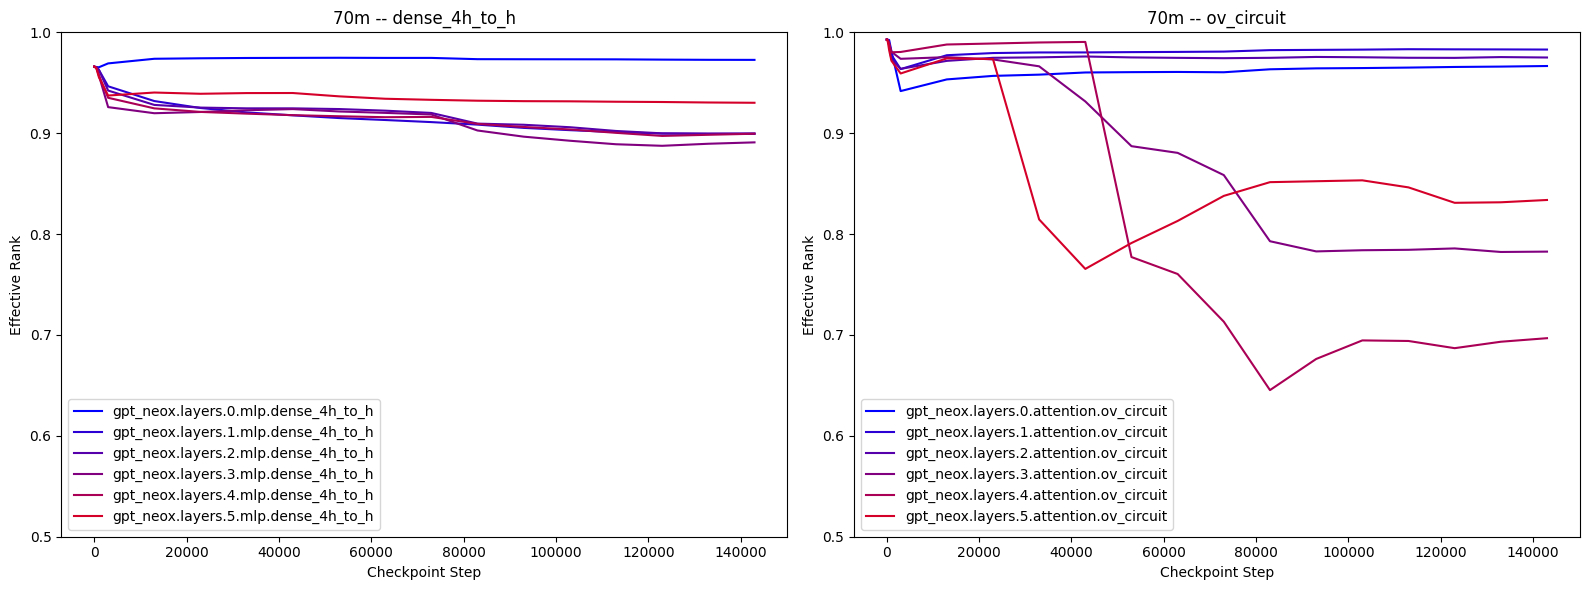

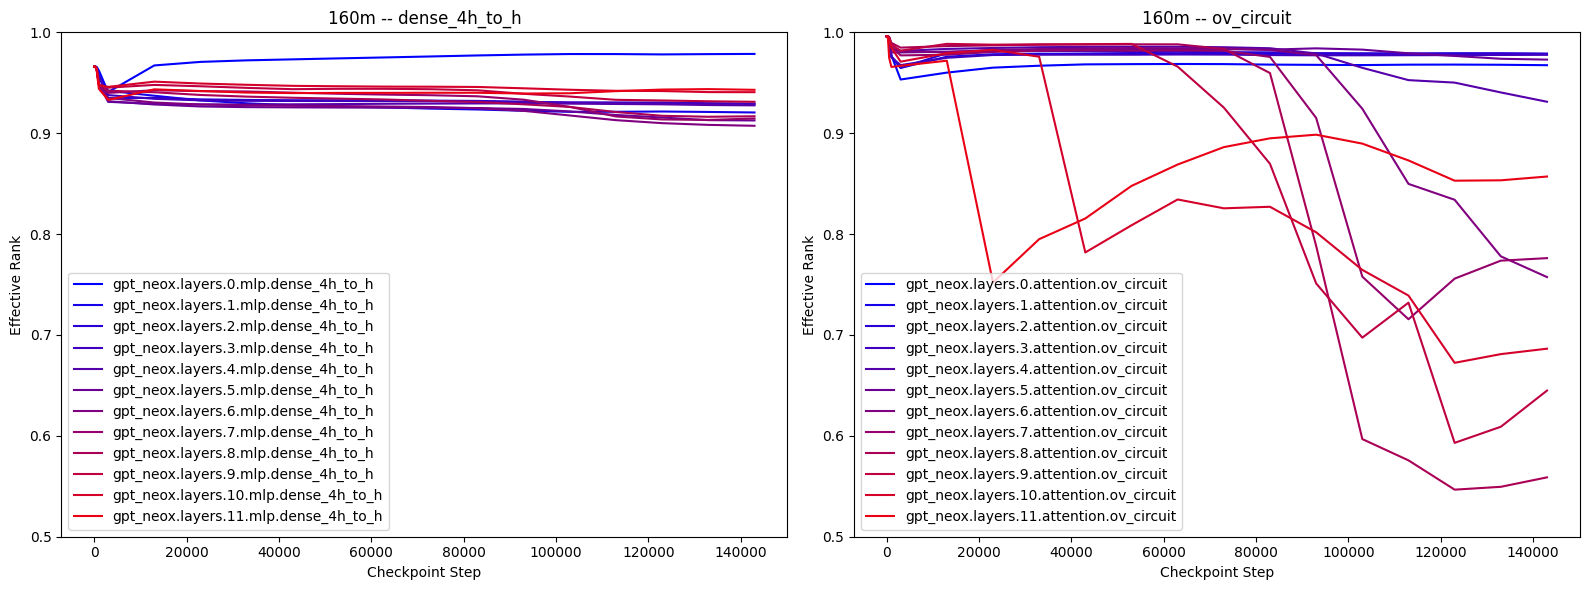

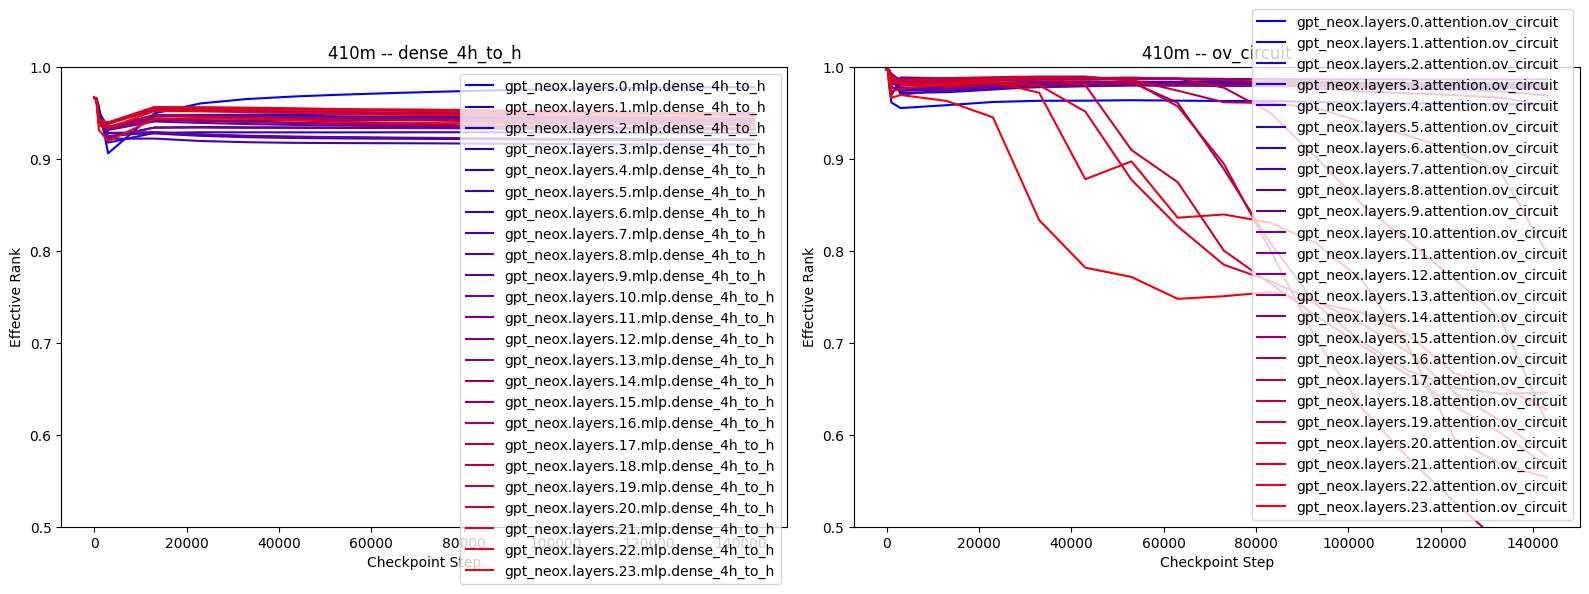

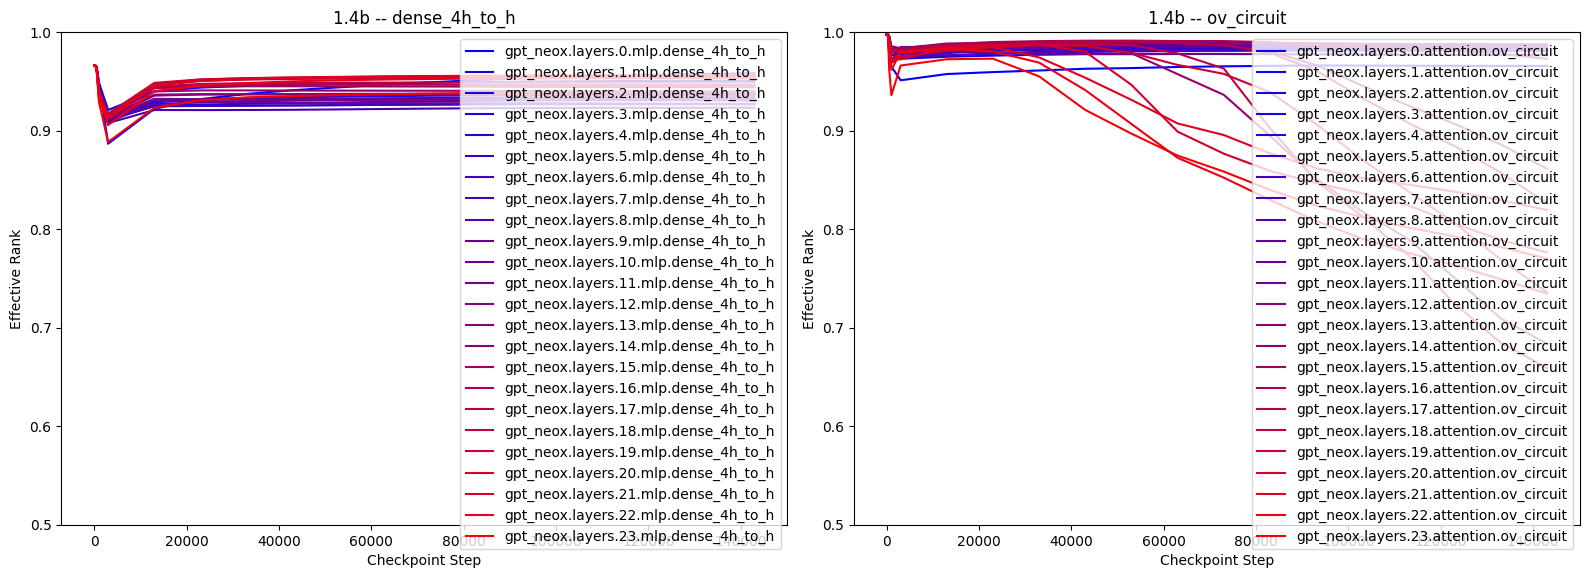

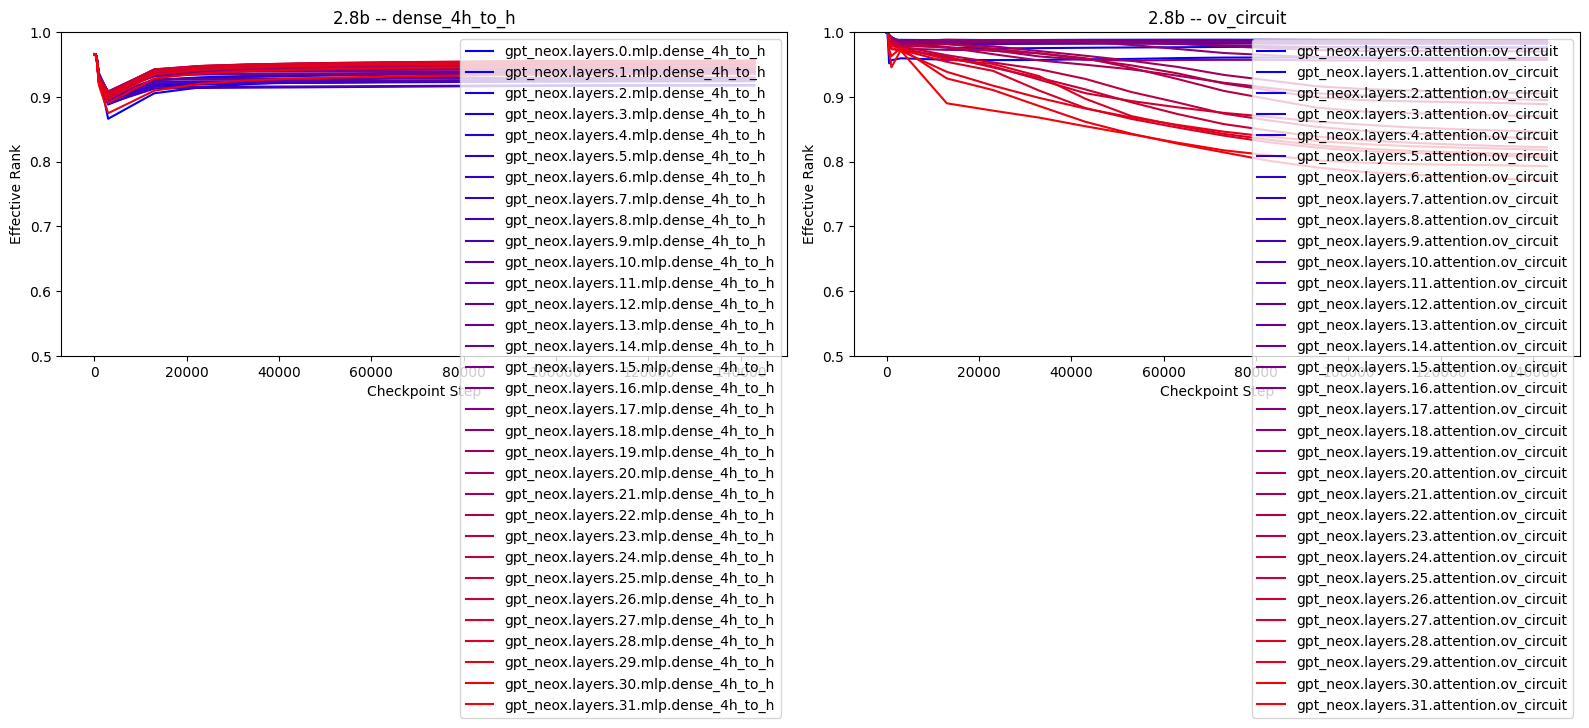

In [79]:
CIRCUIT_NAMES = ["dense_4h_to_h", "ov_circuit"]

for model_size_idx, model_size in enumerate(MODEL_SIZES):
    fix, axs = plt.subplots(1, 2, figsize=(16,6))
    model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

    for circuit_idx, circuit_name in enumerate(CIRCUIT_NAMES): 

        axs[circuit_idx].set_title(f"{model_size} -- {circuit_name}")

        with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
            _svd_weights = pickle.load(f)
            sing_values_weights = sort_and_filter_metrics(_svd_weights, circuit_name, remove_heads=True)

        for layer_idx, (layer_name, layer_singular_values) in enumerate(sing_values_weights.items()):

            matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

            effective_rank = [compute_effective_rank(layer_checkpoint_singular_values, matrix_rank=matrix_rank) for layer_checkpoint_singular_values in layer_singular_values]

            color = (layer_idx / len(sing_values_weights.keys()), 0, 1 - layer_idx / len(sing_values_weights.keys()))

            axs[circuit_idx].plot(CHECKPOINT_STEPS, effective_rank, label=layer_name, color=color)
        
        axs[circuit_idx].legend()
        axs[circuit_idx].set_xlabel("Checkpoint Step")
        axs[circuit_idx].set_ylabel("Effective Rank")
        axs[circuit_idx].set_ylim([0.5, 1.0])
    
    plt.tight_layout()
    plt.show()

Computing **condition number** rank over all layers of a given model size

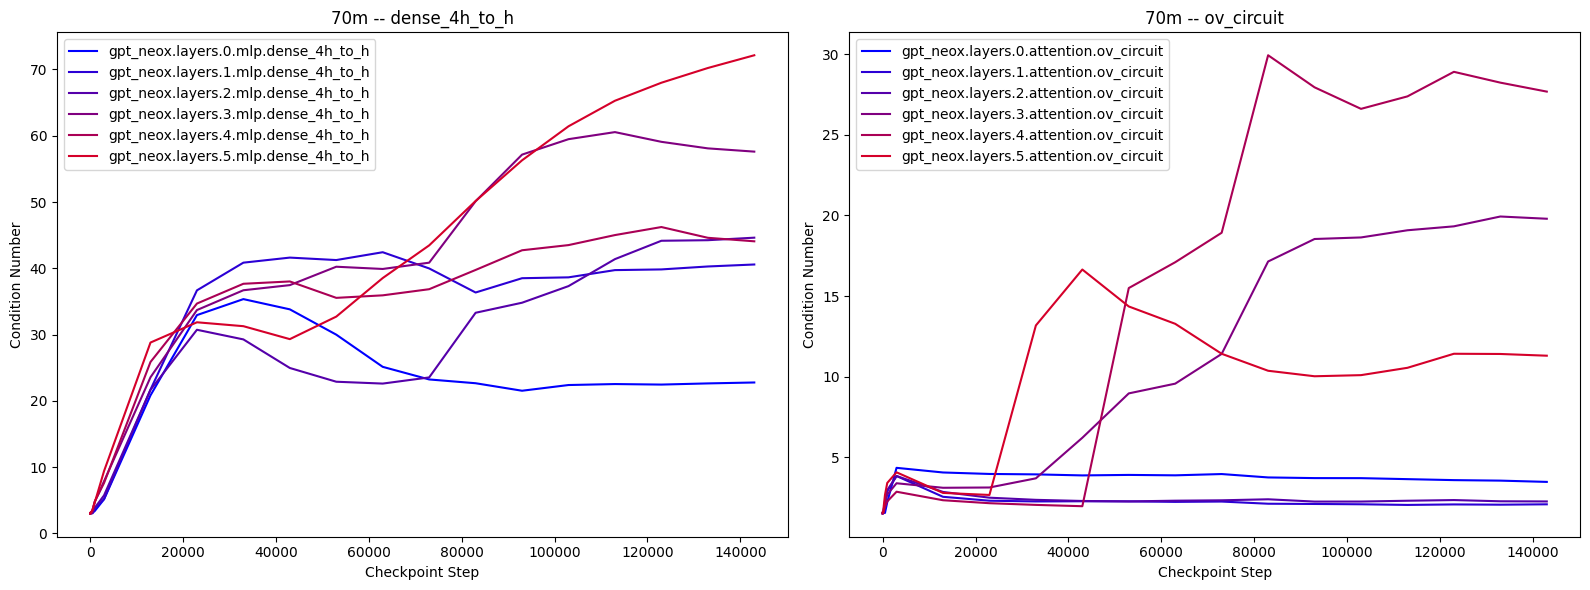

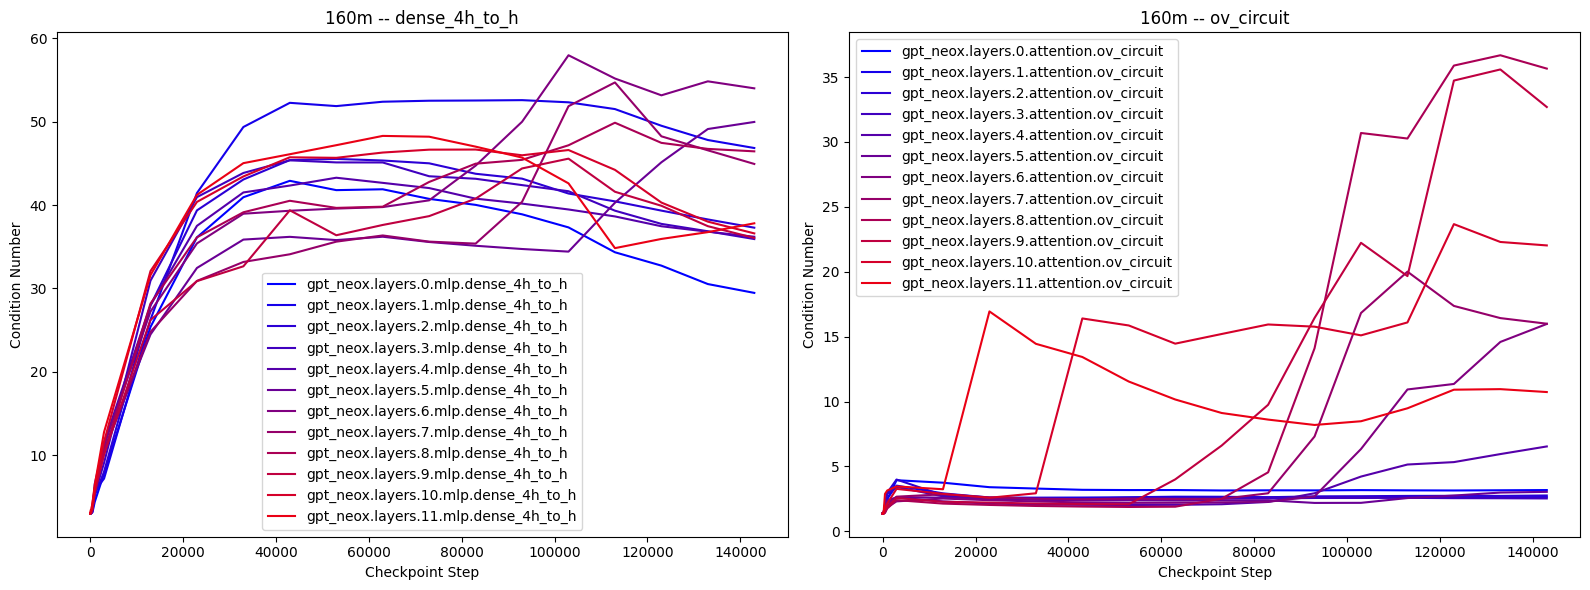

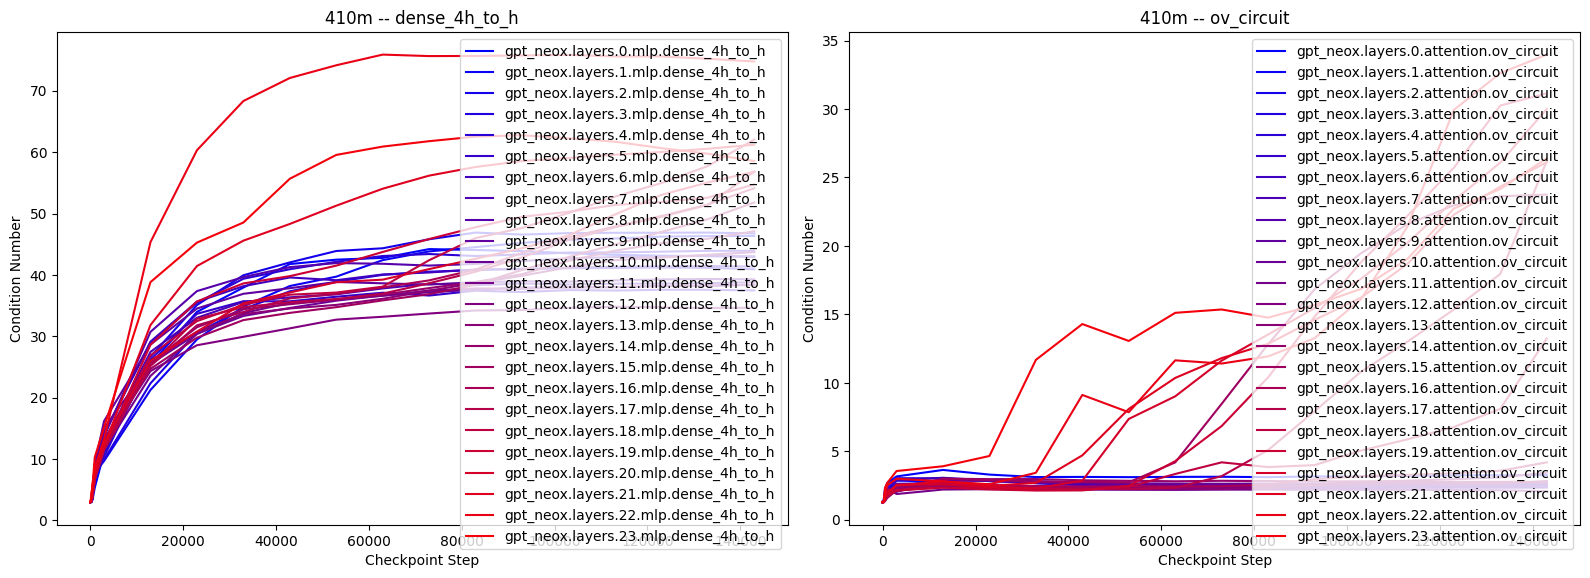

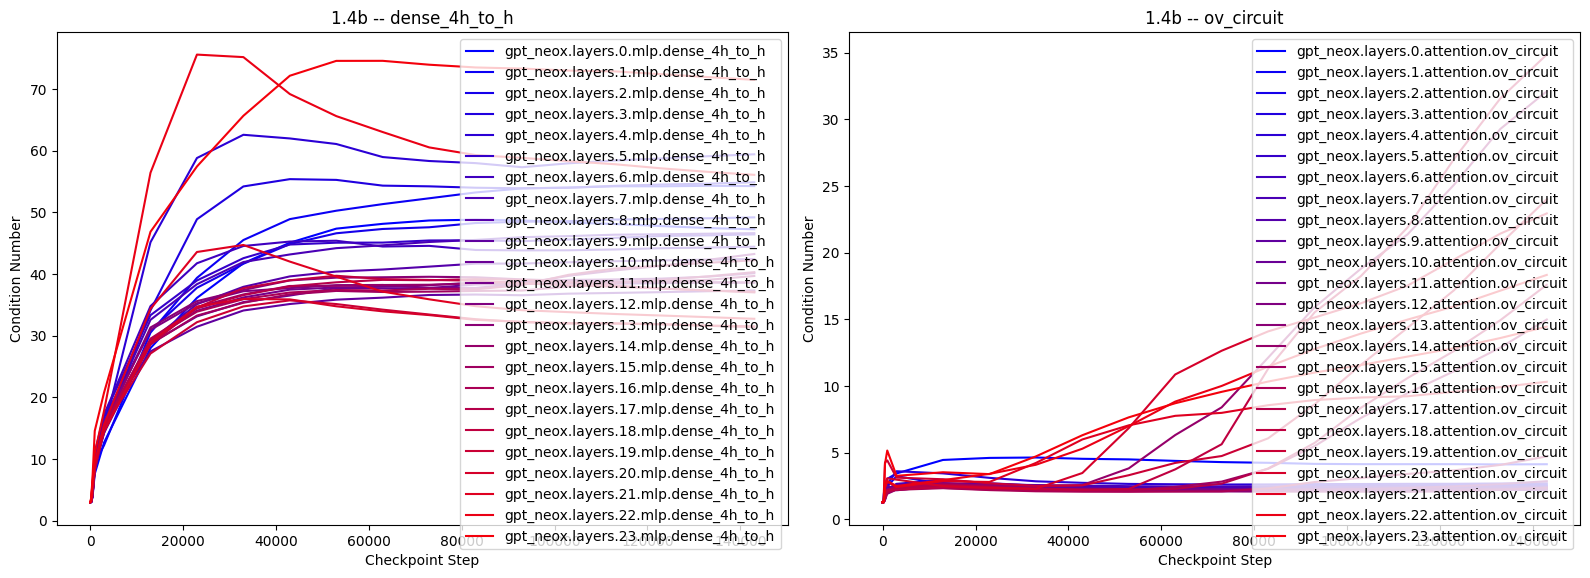

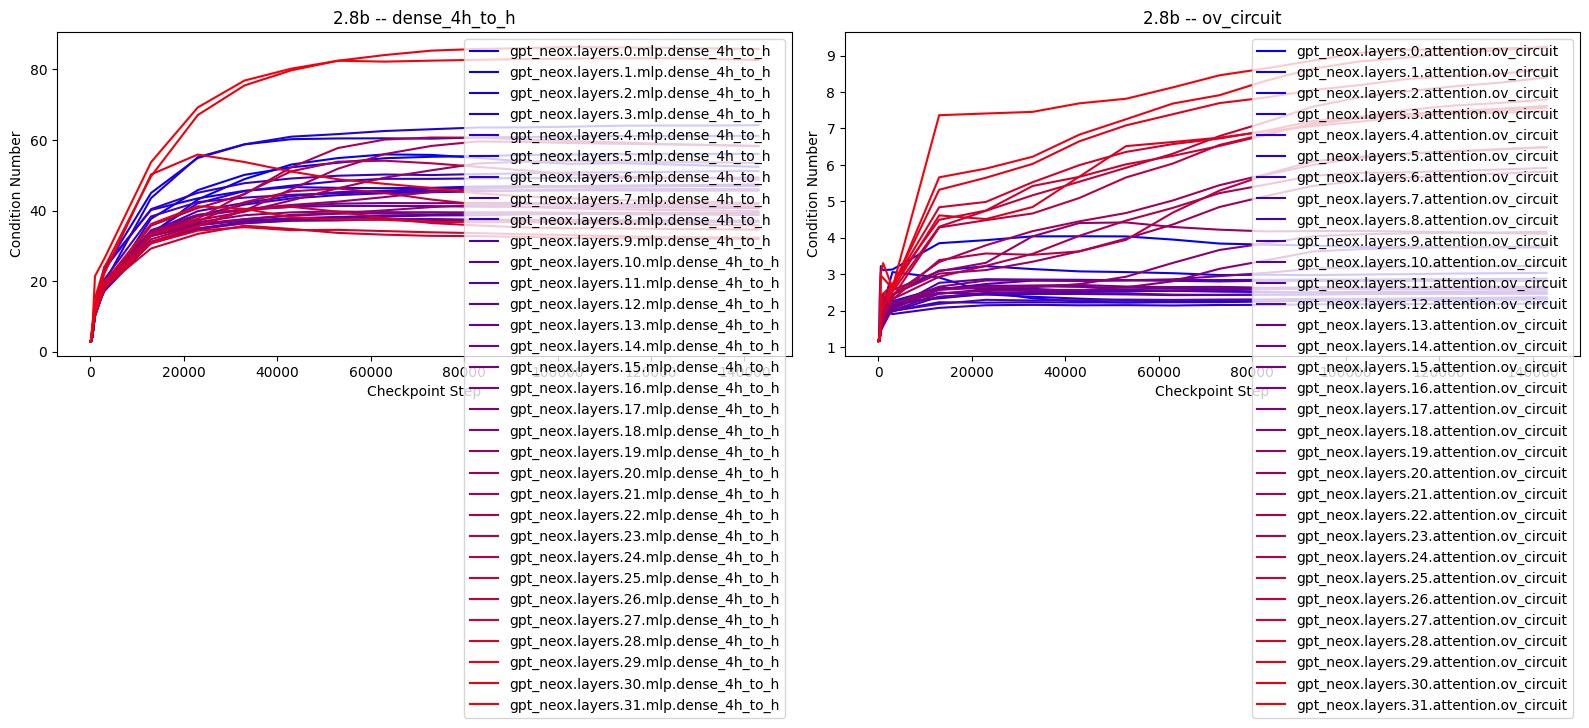

In [76]:
CIRCUIT_NAMES = ["dense_4h_to_h", "ov_circuit"]

for model_size_idx, model_size in enumerate(MODEL_SIZES):
    fix, axs = plt.subplots(1, 2, figsize=(16,6))
    model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

    for circuit_idx, circuit_name in enumerate(CIRCUIT_NAMES): 

        axs[circuit_idx].set_title(f"{model_size} -- {circuit_name}")

        with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
            _svd_weights = pickle.load(f)
            sing_values_weights = sort_and_filter_metrics(_svd_weights, circuit_name, remove_heads=True)

        for layer_idx, (layer_name, layer_singular_values) in enumerate(sing_values_weights.items()):

            matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

            condition_numbers = [compute_condition_number(layer_checkpoint_singular_values, matrix_rank=matrix_rank) for layer_checkpoint_singular_values in layer_singular_values]

            color = (layer_idx / len(sing_values_weights.keys()), 0, 1 - layer_idx / len(sing_values_weights.keys()))

            axs[circuit_idx].plot(CHECKPOINT_STEPS, condition_numbers, label=layer_name, color=color)
        
        axs[circuit_idx].legend()
        axs[circuit_idx].set_xlabel("Checkpoint Step")
        axs[circuit_idx].set_ylabel("Condition Number")
    
    plt.tight_layout()
    plt.show()

 

NOTE: Index 14 in CHECKPOINT_STEPS; maps to CHECKPOINT_STEPS[14]=23_000

In [124]:


for model_size_idx, model_size in enumerate(MODEL_SIZES):

    layer_to_good_cka = dict()
    layer_to_good_effective_rank = dict()

    model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

    with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
        _svd_weights = pickle.load(f)
        sing_values_weights = sort_and_filter_metrics(_svd_weights, "ov_circuit", remove_heads=True)

    with open(f"/home/rd654/pretraining-playground/computed_statistics/{model_size}/cka_scores_per_layer.pkl", "rb") as f:
        _cka_activations = pickle.load(f)
        cka_activations_head = sort_and_filter_metrics(_cka_activations, "ov_circuit", remove_heads=True)
    

    for layer_idx, layer_name in enumerate(sing_values_weights.keys()):

        matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

        critical_effective_rank = compute_effective_rank(sing_values_weights[layer_name][-1], matrix_rank=matrix_rank)

        layer_to_good_effective_rank[layer_name] = critical_effective_rank > 0.95
        critical_cka = cka_activations_head[layer_name][13]
        layer_to_good_cka[layer_name] = critical_cka > 0.45

    
    # find correlation between layer_to_good_cka and layer_to_good_effective_rank
    good_cka = [layer_to_good_cka[layer_name] for layer_name in layer_to_good_cka.keys()]
    good_effective_rank = [layer_to_good_effective_rank[layer_name] for layer_name in layer_to_good_effective_rank.keys()]

    # report the correlation
    print(f"Model size: {model_size} -- Correlation: {np.corrcoef(good_cka, good_effective_rank)[0,1]}")

Model size: 70m -- Correlation: 0.9999999999999998
Model size: 160m -- Correlation: 0.9999999999999998
Model size: 410m -- Correlation: 0.8366600265340758
Model size: 1.4b -- Correlation: 0.7745966692414832
Model size: 2.8b -- Correlation: 0.727606875108999
